<a href="https://colab.research.google.com/github/Aqibaman/Gurobi-Learning/blob/main/Traffic_RL_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0/500, Reward: -2631, Q-Value: -12.16, Epsilon: 0.99, Durations: [ 9 36 40  9]
Episode 50/500, Reward: -3249, Q-Value: -914.65, Epsilon: 0.77, Durations: [21 43 11 19]
Episode 100/500, Reward: -1927, Q-Value: -611.34, Epsilon: 0.60, Durations: [33 12 50 39]
Episode 150/500, Reward: -2763, Q-Value: -1008.65, Epsilon: 0.47, Durations: [39 36 16 37]
Episode 200/500, Reward: -2841, Q-Value: -764.00, Epsilon: 0.37, Durations: [21 21 10  6]
Episode 250/500, Reward: -4385, Q-Value: -1595.95, Epsilon: 0.28, Durations: [37 39  5 16]
Episode 300/500, Reward: -3363, Q-Value: -1169.27, Epsilon: 0.22, Durations: [46 37 28 14]
Episode 350/500, Reward: -2503, Q-Value: -345.30, Epsilon: 0.17, Durations: [ 5 14 13 23]
Episode 400/500, Reward: -3159, Q-Value: -1043.19, Epsilon: 0.13, Durations: [41 41 22 33]
Episode 450/500, Reward: -2275, Q-Value: -577.96, Epsilon: 0.10, Durations: [11 18 10 28]


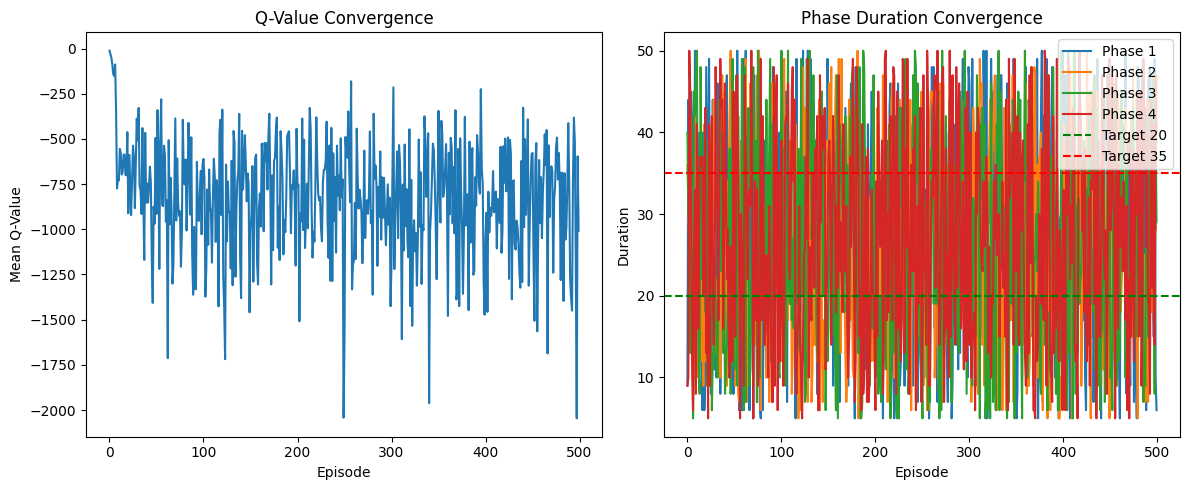


Final Q-values for state [11 39 37 15] : [[-962.52527 -951.1688  -951.71924 -948.3942 ]]


In [1]:
# traffic_rl_optimizer.py

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# ----------------------
# Environment Definition
# ----------------------
class TrafficEnv:
    def __init__(self):
        self.phases = [0, 1, 2, 3]  # Four traffic light phase actions
        self.goal_durations = [20, 20, 35, 35]  # Optimal durations
        self.max_duration = 50
        self.state = np.random.randint(5, 50, size=4)  # Initial random durations for each phase
        self.action_space = len(self.phases)
        self.observation_space = len(self.state)

    def step(self, action):
        # Action: increment or decrement duration of selected phase to get closer to optimal
        delta = np.random.choice([-1, 1])  # Adjust duration randomly up/down
        self.state[action] = np.clip(self.state[action] + delta, 5, self.max_duration)

        # Reward is negative sum of distance from goal durations
        distance = np.abs(np.array(self.state) - np.array(self.goal_durations))
        reward = -np.sum(distance)

        done = np.all(distance <= 1)  # Done if all durations match goal
        return np.array(self.state), reward, done

    def reset(self):
        self.state = np.random.randint(5, 50, size=4)
        return np.array(self.state)

# ----------------------
# DQN Agent Definition
# ----------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Network for Deep-Q learning
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)
            target_f[0][action] = target
            self.model.fit(state[np.newaxis], target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_q_values(self, state):
        return self.model.predict(state[np.newaxis], verbose=0)

# ----------------------
# Training
# ----------------------

env = TrafficEnv()
state_size = env.observation_space
action_size = env.action_space
agent = DQNAgent(state_size, action_size)

EPISODES = 500
q_convergence = []
phase_tracking = []

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0
    for time in range(50):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    q_val = np.mean(agent.get_q_values(state))
    q_convergence.append(q_val)
    phase_tracking.append(state.copy())

    if e % 50 == 0:
        print(f"Episode {e}/{EPISODES}, Reward: {total_reward}, Q-Value: {q_val:.2f}, Epsilon: {agent.epsilon:.2f}, Durations: {state}")

# ----------------------
# Plotting Results
# ----------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(q_convergence)
plt.title("Q-Value Convergence")
plt.xlabel("Episode")
plt.ylabel("Mean Q-Value")

plt.subplot(1, 2, 2)
phase_tracking = np.array(phase_tracking)
for i in range(4):
    plt.plot(phase_tracking[:, i], label=f"Phase {i+1}")
plt.axhline(y=20, color='g', linestyle='--', label='Target 20')
plt.axhline(y=35, color='r', linestyle='--', label='Target 35')
plt.title("Phase Duration Convergence")
plt.xlabel("Episode")
plt.ylabel("Duration")
plt.legend()
plt.tight_layout()
plt.show()

# Verify final Q-values
final_state = env.reset()
final_qs = agent.get_q_values(final_state)
print("\nFinal Q-values for state", final_state, ":", final_qs)